# SED plots
Here we present the galaxy with the best SED in the models presented by Stalevski et. al 2012, 2016 [(SKIRTOR)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.458.2288S/abstract) and Fritz et. al 2006 [(Fritz)](https://ui.adsabs.harvard.edu/abs/2006MNRAS.366..767F/abstract). First, we import all important packages.

In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.units as u
from astropy.table import Table, join

We then read the photometry and the clean outputs from CIGALE

In [3]:
phot = Table.read('../Data/Final/CIGPhot_EnergyBal_All.tbl', format='ascii')

In [4]:
ModelS = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_SK.fits', format='fits')
ModelF = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_Fr.fits', format='fits')

We count the number of photometry points for the SED fitting for each galaxy and join with the previous Tables.

In [5]:
phot['CountPoints'] = [sum(~np.isnan(list(j))) /
                       2 for j in phot[phot.colnames[2:]].as_array()]
PhotS = join(phot, ModelS)
PhotF = join(phot, ModelF)

Finally, we join both tables into one to select only galaxies where we have satisfiying results in both models

In [6]:
PhotAll = join(PhotS, PhotF, keys=('id', 'redshift', 'CountPoints'),
               table_names=['S', 'F'])

## Select best and worst SED fittings

For the best galaxy, we select galaxies with more than 20 photometry points and $\chi_{\rm{red}}^{2}$ values close to 1.

In [7]:
AllS_chis = PhotAll['best.reduced_chi_square_S']
AllF_chis = PhotAll['best.reduced_chi_square_F']

SelecCut = np.logical_and.reduce([AllS_chis < 1.2, AllF_chis < 1.2,
                                  AllS_chis > 0.8, AllF_chis > 0.8,
                                  PhotAll['CountPoints'] >= 20])

In [8]:
PhotAll[SelecCut]

id,redshift,FUV_S,FUV_err_S,NUV_S,NUV_err_S,u_prime_S,u_prime_err_S,g_prime_S,g_prime_err_S,r_prime_S,r_prime_err_S,i_prime_S,i_prime_err_S,z_prime_S,z_prime_err_S,J_2mass_S,J_2mass_err_S,H_2mass_S,H_2mass_err_S,Ks_2mass_S,Ks_2mass_err_S,WISE1_S,WISE1_err_S,IRAC1_S,IRAC1_err_S,IRAC2_S,IRAC2_err_S,WISE2_S,WISE2_err_S,IRAC3_S,IRAC3_err_S,IRAC4_S,IRAC4_err_S,IRAS1_S,IRAS1_err_S,WISE3_S,WISE3_err_S,WISE4_S,WISE4_err_S,MIPS1_S,MIPS1_err_S,IRAS2_S,IRAS2_err_S,IRAS3_S,IRAS3_err_S,PACS_blue_S,PACS_blue_err_S,MIPS2_S,MIPS2_err_S,IRAS4_S,IRAS4_err_S,PACS_green_S,PACS_green_err_S,MIPS3_S,MIPS3_err_S,PACS_red_S,PACS_red_err_S,PSW_ext_S,PSW_ext_err_S,PMW_ext_S,PMW_ext_err_S,PLW_ext_S,PLW_ext_err_S,CountPoints,bayes.agn.EBV_S,bayes.agn.EBV_err_S,bayes.agn.Mcl,bayes.agn.Mcl_err,bayes.agn.R,bayes.agn.R_err,bayes.agn.emissivity_S,bayes.agn.emissivity_err_S,bayes.agn.fracAGN_S,bayes.agn.fracAGN_err_S,bayes.agn.fracAGN_dale2014_S,bayes.agn.fracAGN_dale2014_err_S,bayes.agn.i_S,bayes.agn.i_err_S,bayes.agn.law_S,bayes.agn.law_err_S,bayes.agn.oa,bayes.agn.oa_err,bayes.agn.pl,bayes.agn.pl_err,bayes.agn.q,bayes.agn.q_err,bayes.agn.t,bayes.agn.t_err,bayes.agn.temperature_S,bayes.agn.temperature_err_S,bayes.attenuation.E_BV_factor_S,bayes.attenuation.E_BV_factor_err_S,bayes.attenuation.E_BV_lines_S,bayes.attenuation.E_BV_lines_err_S,bayes.attenuation.E_BVs_S,bayes.attenuation.E_BVs_err_S,bayes.attenuation.FUV_S,bayes.attenuation.FUV_err_S,bayes.attenuation.powerlaw_slope_S,bayes.attenuation.powerlaw_slope_err_S,bayes.attenuation.uv_bump_amplitude_S,bayes.attenuation.uv_bump_amplitude_err_S,bayes.attenuation.uv_bump_wavelength_S,bayes.attenuation.uv_bump_wavelength_err_S,bayes.attenuation.uv_bump_width_S,bayes.attenuation.uv_bump_width_err_S,bayes.dust.alpha_S,bayes.dust.alpha_err_S,bayes.nebular.f_dust_S,bayes.nebular.f_dust_err_S,bayes.nebular.f_esc_S,bayes.nebular.f_esc_err_S,bayes.nebular.lines_width_S,bayes.nebular.lines_width_err_S,bayes.nebular.logU_S,bayes.nebular.logU_err_S,bayes.sfh.age_S,bayes.sfh.age_err_S,bayes.sfh.age_burst_S,bayes.sfh.age_burst_err_S,bayes.sfh.age_main_S,bayes.sfh.age_main_err_S,bayes.sfh.f_burst_S,bayes.sfh.f_burst_err_S,bayes.sfh.tau_burst_S,bayes.sfh.tau_burst_err_S,bayes.sfh.tau_main_S,bayes.sfh.tau_main_err_S,bayes.stellar.age_m_star_S,bayes.stellar.age_m_star_err_S,bayes.stellar.imf_S,bayes.stellar.imf_err_S,bayes.stellar.metallicity_S,bayes.stellar.metallicity_err_S,bayes.stellar.old_young_separation_age_S,bayes.stellar.old_young_separation_age_err_S,bayes.universe.age_S,bayes.universe.age_err_S,bayes.universe.luminosity_distance_S,bayes.universe.luminosity_distance_err_S,bayes.universe.redshift_S,bayes.universe.redshift_err_S,bayes.agn.accretion_power_S,bayes.agn.accretion_power_err_S,bayes.agn.disk_luminosity_S,bayes.agn.disk_luminosity_err_S,bayes.agn.dust_luminosity_S,bayes.agn.dust_luminosity_err_S,bayes.agn.intrin_Lnu_2500A_S,bayes.agn.intrin_Lnu_2500A_err_S,bayes.agn.luminosity_S,bayes.agn.luminosity_err_S,bayes.dust.luminosity_S,bayes.dust.luminosity_err_S,bayes.sfh.integrated_S,bayes.sfh.integrated_err_S,bayes.sfh.sfr_S,bayes.sfh.sfr_err_S,bayes.sfh.sfr100Myrs_S,bayes.sfh.sfr100Myrs_err_S,bayes.sfh.sfr10Myrs_S,bayes.sfh.sfr10Myrs_err_S,bayes.stellar.lum_S,bayes.stellar.lum_err_S,bayes.stellar.lum_ly_S,bayes.stellar.lum_ly_err_S,bayes.stellar.lum_ly_old_S,bayes.stellar.lum_ly_old_err_S,bayes.stellar.lum_ly_young_S,bayes.stellar.lum_ly_young_err_S,bayes.stellar.lum_old_S,bayes.stellar.lum_old_err_S,bayes.stellar.lum_young_S,bayes.stellar.lum_young_err_S,bayes.stellar.m_gas_S,bayes.stellar.m_gas_err_S,bayes.stellar.m_gas_old_S,bayes.stellar.m_gas_old_err_S,bayes.stellar.m_gas_young_S,bayes.stellar.m_gas_young_err_S,bayes.stellar.m_star_S,bayes.stellar.m_star_err_S,bayes.stellar.m_star_old_S,bayes.stellar.m_star_old_err_S,bayes.stellar.m_star_young_S,bayes.stellar.m_star_young_err_S,bayes.stellar.n_ly_S,bayes.stellar.n_ly_err_S,bayes.stellar.n_ly_old_S,bayes.stellar.n_ly_old_err_S,bayes.stellar.n_ly_young_S,bay

We select Mrk 662 galaxy as the best SED fitting (Due to its $\chi_{\rm{red}}^{2}$ values).

In [9]:
BEST_GAL = 'Mrk  662'

For the worst galaxy, we select a galaxy with a $\chi_{\rm{red}}^{2}$ close to our selected limits in the $\chi_{\rm{red}}^{2}$ distribution (See FIGURE 2), with less or equal to 9 photometry points

In [10]:
WorstCut = np.logical_and.reduce([np.logical_xor(AllS_chis < 10**(0.49),
                                                 AllS_chis > 10**(-0.49)),
                                  np.logical_xor(AllF_chis < 10**(0.49),
                                                 AllF_chis > 10**(-0.49)),
                                  PhotAll['CountPoints'] <= 9])

In [11]:
PhotAll[WorstCut]

id,redshift,FUV_S,FUV_err_S,NUV_S,NUV_err_S,u_prime_S,u_prime_err_S,g_prime_S,g_prime_err_S,r_prime_S,r_prime_err_S,i_prime_S,i_prime_err_S,z_prime_S,z_prime_err_S,J_2mass_S,J_2mass_err_S,H_2mass_S,H_2mass_err_S,Ks_2mass_S,Ks_2mass_err_S,WISE1_S,WISE1_err_S,IRAC1_S,IRAC1_err_S,IRAC2_S,IRAC2_err_S,WISE2_S,WISE2_err_S,IRAC3_S,IRAC3_err_S,IRAC4_S,IRAC4_err_S,IRAS1_S,IRAS1_err_S,WISE3_S,WISE3_err_S,WISE4_S,WISE4_err_S,MIPS1_S,MIPS1_err_S,IRAS2_S,IRAS2_err_S,IRAS3_S,IRAS3_err_S,PACS_blue_S,PACS_blue_err_S,MIPS2_S,MIPS2_err_S,IRAS4_S,IRAS4_err_S,PACS_green_S,PACS_green_err_S,MIPS3_S,MIPS3_err_S,PACS_red_S,PACS_red_err_S,PSW_ext_S,PSW_ext_err_S,PMW_ext_S,PMW_ext_err_S,PLW_ext_S,PLW_ext_err_S,CountPoints,bayes.agn.EBV_S,bayes.agn.EBV_err_S,bayes.agn.Mcl,bayes.agn.Mcl_err,bayes.agn.R,bayes.agn.R_err,bayes.agn.emissivity_S,bayes.agn.emissivity_err_S,bayes.agn.fracAGN_S,bayes.agn.fracAGN_err_S,bayes.agn.fracAGN_dale2014_S,bayes.agn.fracAGN_dale2014_err_S,bayes.agn.i_S,bayes.agn.i_err_S,bayes.agn.law_S,bayes.agn.law_err_S,bayes.agn.oa,bayes.agn.oa_err,bayes.agn.pl,bayes.agn.pl_err,bayes.agn.q,bayes.agn.q_err,bayes.agn.t,bayes.agn.t_err,bayes.agn.temperature_S,bayes.agn.temperature_err_S,bayes.attenuation.E_BV_factor_S,bayes.attenuation.E_BV_factor_err_S,bayes.attenuation.E_BV_lines_S,bayes.attenuation.E_BV_lines_err_S,bayes.attenuation.E_BVs_S,bayes.attenuation.E_BVs_err_S,bayes.attenuation.FUV_S,bayes.attenuation.FUV_err_S,bayes.attenuation.powerlaw_slope_S,bayes.attenuation.powerlaw_slope_err_S,bayes.attenuation.uv_bump_amplitude_S,bayes.attenuation.uv_bump_amplitude_err_S,bayes.attenuation.uv_bump_wavelength_S,bayes.attenuation.uv_bump_wavelength_err_S,bayes.attenuation.uv_bump_width_S,bayes.attenuation.uv_bump_width_err_S,bayes.dust.alpha_S,bayes.dust.alpha_err_S,bayes.nebular.f_dust_S,bayes.nebular.f_dust_err_S,bayes.nebular.f_esc_S,bayes.nebular.f_esc_err_S,bayes.nebular.lines_width_S,bayes.nebular.lines_width_err_S,bayes.nebular.logU_S,bayes.nebular.logU_err_S,bayes.sfh.age_S,bayes.sfh.age_err_S,bayes.sfh.age_burst_S,bayes.sfh.age_burst_err_S,bayes.sfh.age_main_S,bayes.sfh.age_main_err_S,bayes.sfh.f_burst_S,bayes.sfh.f_burst_err_S,bayes.sfh.tau_burst_S,bayes.sfh.tau_burst_err_S,bayes.sfh.tau_main_S,bayes.sfh.tau_main_err_S,bayes.stellar.age_m_star_S,bayes.stellar.age_m_star_err_S,bayes.stellar.imf_S,bayes.stellar.imf_err_S,bayes.stellar.metallicity_S,bayes.stellar.metallicity_err_S,bayes.stellar.old_young_separation_age_S,bayes.stellar.old_young_separation_age_err_S,bayes.universe.age_S,bayes.universe.age_err_S,bayes.universe.luminosity_distance_S,bayes.universe.luminosity_distance_err_S,bayes.universe.redshift_S,bayes.universe.redshift_err_S,bayes.agn.accretion_power_S,bayes.agn.accretion_power_err_S,bayes.agn.disk_luminosity_S,bayes.agn.disk_luminosity_err_S,bayes.agn.dust_luminosity_S,bayes.agn.dust_luminosity_err_S,bayes.agn.intrin_Lnu_2500A_S,bayes.agn.intrin_Lnu_2500A_err_S,bayes.agn.luminosity_S,bayes.agn.luminosity_err_S,bayes.dust.luminosity_S,bayes.dust.luminosity_err_S,bayes.sfh.integrated_S,bayes.sfh.integrated_err_S,bayes.sfh.sfr_S,bayes.sfh.sfr_err_S,bayes.sfh.sfr100Myrs_S,bayes.sfh.sfr100Myrs_err_S,bayes.sfh.sfr10Myrs_S,bayes.sfh.sfr10Myrs_err_S,bayes.stellar.lum_S,bayes.stellar.lum_err_S,bayes.stellar.lum_ly_S,bayes.stellar.lum_ly_err_S,bayes.stellar.lum_ly_old_S,bayes.stellar.lum_ly_old_err_S,bayes.stellar.lum_ly_young_S,bayes.stellar.lum_ly_young_err_S,bayes.stellar.lum_old_S,bayes.stellar.lum_old_err_S,bayes.stellar.lum_young_S,bayes.stellar.lum_young_err_S,bayes.stellar.m_gas_S,bayes.stellar.m_gas_err_S,bayes.stellar.m_gas_old_S,bayes.stellar.m_gas_old_err_S,bayes.stellar.m_gas_young_S,bayes.stellar.m_gas_young_err_S,bayes.stellar.m_star_S,bayes.stellar.m_star_err_S,bayes.stellar.m_star_old_S,bayes.stellar.m_star_old_err_S,bayes.stellar.m_star_young_S,bayes.stellar.m_star_young_err_S,bayes.stellar.n_ly_S,bayes.stellar.n_ly_err_S,bayes.stellar.n_ly_old_S,bayes.stellar.n_ly_old_err_S,bayes.stellar.n_ly_young_S,bay

Then, the worst galaxy is 2dFGRS TGN366Z095, the only one with the selection requirements.

In [12]:
WORST_GAL = '2dFGRS TGN366Z095'

## Plot 4 SEDs in one figure
We retrieve the respective files to create the SEDs for the best and worst galaxies. These files are originally located in a [complementary repository for all the galaxies in Zenodo](https:/doi.org/10.5281/zenodo.NNNNNN). Then, we compare the different AGN models.

In [13]:
folders = ['FrAGN_1', 'FrAGN37', 'SKAGN0', 'SKAGN_1', 'SKAGN37']
labels_ver = ['Fritz', 'Fritz 30/70', 'No-AGN', 'SKIRTOR', 'SKIRTOR 30/70']
wavelengths = {"FUV": 0.152, "NUV": 0.227, "u_prime": 0.354, "g_prime": 0.477,
               "r_prime": 0.623, "i_prime": 0.762, "z_prime": 0.913, "J_2mass": 1.25,
               "H_2mass": 1.65, "Ks_2mass": 2.17, "WISE1": 3.4, "IRAC1": 3.6, "IRAC2": 4.5,
               "WISE2": 4.6, "IRAC3": 5.8, "IRAC4": 8.0, "IRAS1": 12.0, "WISE3": 12.0,
               "WISE4": 22.0, "MIPS1": 24.0, "IRAS2": 25.0, "IRAS3": 60.0, "PACS_blue": 70.0,
               "MIPS2": 70.0, "PACS_green": 100.0, "IRAS4": 100.0, "PACS_red": 160.0,
               "MIPS3": 160.0, "PSW_ext": 250.0, "PMW_ext": 350.0, "PLW_ext": 500.0}
FOLDER_FILES = '../Data/Complementary/ExampleSEDs/'

In [14]:
phot.remove_column('CountPoints')  # We remove the CounPhot from the Phot

##### FIGURE 2
We define a function that helps us to plot the 5 SEDs into one figure.

In [15]:
def five_seds(row_gal):
    """Create a figure with 5 SEDs for a given galaxy"""
    fig, axs = plt.subplots(2, 3,
                            figsize=(16, 9), sharey=True)
    fig.delaxes(axs[-1][-1])
    axs = axs.flatten()[:-1]
    for i_fol, v_file in enumerate(folders):
        file_sed = Table.read(FOLDER_FILES+row_gal+'_best_model_'+v_file+'.fits')
        modr = Table.read('../Data/Interim/CIGALEOutputs/results_'+v_file+'.fits')
        if i_fol > 1:
            file_sed['agn'] = (file_sed['agn.SKIRTOR2016_dust'] +
                               file_sed['agn.SKIRTOR2016_disk'])
        else:
            file_sed['agn'] = (file_sed['agn.fritz2006_agn'] +
                               file_sed['agn.fritz2006_therm'] +
                               file_sed['agn.fritz2006_scatt'])  # Take all the AGN emission
        file_sed['freq'] = file_sed['wavelength'].to(u.Hz,
                                                     equivalencies=u.spectral())
        file_sed['stellar'] = file_sed['stellar.old'] + file_sed['stellar.young']
        file_sed['stellar_atten'] = (file_sed['stellar.old']+file_sed['stellar.young']+
                                     file_sed['attenuation.stellar.old'] +
                                     file_sed['attenuation.stellar.young']+
                                     file_sed['nebular.absorption_old'] +
                                     file_sed['nebular.absorption_young'])
        file_sed['nebular'] = (file_sed['nebular.lines_old'] +
                               file_sed['nebular.lines_young'] +
                               file_sed['nebular.continuum_old'] +
                               file_sed['nebular.continuum_young'] +
                               file_sed['attenuation.nebular.lines_old'] +
                               file_sed['attenuation.nebular.lines_young'] +
                               file_sed['attenuation.nebular.lines_old'] +
                               file_sed['attenuation.nebular.continuum_young'])
        # This is to define the distance
        locat = np.where(modr['id'] == row_gal)
        cons = (modr['best.universe.luminosity_distance'][locat])**2 * u.m
        # Here we create the subplots
        axs[i_fol].plot(file_sed['wavelength'].to(u.um),
                        (((file_sed['stellar']*file_sed['wavelength'].to(u.m)).to(u.W)) /
                         (cons*4*np.pi)/file_sed['freq']).to(u.mJy),
                        'b', linewidth=1, linestyle='-.',
                        label='Stellar unattenuated')
        axs[i_fol].plot(file_sed['wavelength'].to(u.um),
                        (((file_sed['stellar_atten']*file_sed['wavelength'].to(u.m)).to(u.W)) /
                         (cons*4*np.pi)/file_sed['freq']).to(u.mJy),
                        'orange', linewidth=1, linestyle='-',
                        label='Stellar attenuated')
        axs[i_fol].plot(file_sed['wavelength'].to(u.um),
                        (((file_sed['nebular']*file_sed['wavelength'].to(u.m)).to(u.W)) /
                         (cons*4*np.pi)/file_sed['freq']).to(u.mJy),
                        'y', linewidth=1, linestyle=':',
                        label='Nebular emission')
        axs[i_fol].plot(file_sed['wavelength'].to(u.um),
                        (((file_sed['dust']*file_sed['wavelength'].to(u.m)).to(u.W)) /
                         (cons*4*np.pi)/file_sed['freq']).to(u.mJy),
                        'r', linewidth=1, label='Dust emission')
        axs[i_fol].plot(file_sed['wavelength'].to(u.um),
                        (((file_sed['agn']*file_sed['wavelength'].to(u.m)).to(u.W)) /
                         (cons*4*np.pi)/file_sed['freq']).to(u.mJy),
                        'g', linewidth=2, linestyle='--',
                        label='AGN emission')
        axs[i_fol].plot(file_sed['wavelength'].to(u.um), file_sed['Fnu'],
                        'k', linewidth=2, label='Model spectrum')
        filters = [phot.colnames[x] for x in range(2, len(phot.colnames), 2)]
        # It will be useful to create a dictionary for each band that you use
        for i_filter, band in enumerate(filters):
            axs[i_fol].errorbar(wavelengths[band], phot[str(band)][loc_gal],
                                yerr=phot[str(band)+'_err'][loc_gal],
                                color='b', fmt='o', elinewidth=2,
                                markersize=5, markeredgewidth=1,
                                markeredgecolor='b', markerfacecolor="None",
                                label='Observed flux densities' if i_filter == 1 else None)
            axs[i_fol].plot(wavelengths[band], modr["best."+band][locat].data,
                            'ro', markersize=5,
                            label='Model flux densities' if i_filter == 1 else None)
            if i_fol == 0 and i_filter == 0:
                min_phot = np.nanmin([phot[str(band)].data[0],
                                      modr["best."+band][locat].data[0], np.nan])
                max_phot = np.nanmax([phot[str(band)].data[0],
                                      modr["best."+band][locat].data[0], np.nan])
            else:
                min_phot = np.nanmin([phot[str(band)].data[0],
                                      modr["best."+band][locat].data[0], min_phot])
                max_phot = np.nanmax([phot[str(band)].data[0],
                                      modr["best."+band][locat].data[0], max_phot])
        axs[i_fol].set_xscale('log')
        axs[i_fol].set_yscale('log')
        axs[i_fol].set_xlim(0.5e-1, 2e4)
        # To give some space at the borders
        axs[i_fol].set_ylim(min_phot/3, max_phot*5)
        axs[i_fol].annotate(labels_ver[i_fol]+'\n'+r"$\chi^2_{\rm{red}}$ = %1.3f"
                            % modr['best.reduced_chi_square'][locat].data[0],
                            xy=(0.3, 0.8), horizontalalignment='center', fontsize=11,
                            xycoords='axes fraction')
        if i_fol in (0, 3):
            axs[i_fol].set_ylabel(r'Flux Density [mJy]', fontsize=14)
        if i_fol in (2, 3, 4):
            axs[i_fol].set_xlabel(r'Observed wavelength [$\mu$m]', fontsize=14)
        if i_fol == 4:
            axs[i_fol].legend(bbox_to_anchor=(1.25, 0.75),
                              loc='upper left', borderaxespad=0., fontsize=10)
            axs[i_fol].annotate("Galaxy ID: "+row_gal, xy=(1.5, 0.10),
                                horizontalalignment='center', fontsize=13,
                                xycoords='axes fraction', weight='bold')
    plt.subplots_adjust(wspace=0, hspace=0)

The galaxy with the best SED fitting is used as an example and presented as a figure in the paper.

In [16]:
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    loc_gal = np.where(phot['id'] == BEST_GAL)[0]
    five_seds(BEST_GAL)
    plt.savefig('../Figures/F2.pdf', dpi=300, bbox_inches='tight')  # For Paper
#     plt.savefig('../Talk_Figures/F2.png',dpi=300,bbox_inches = 'tight') # For Presentation

Here, we show the worst result for a galaxy inside the $\chi_{\rm{red}}^{2}$ limits.

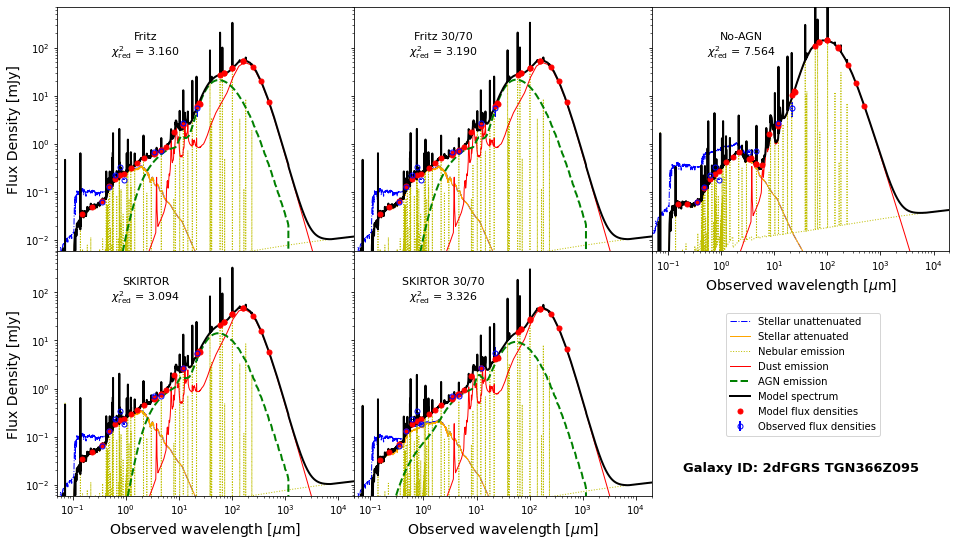

In [17]:
%matplotlib inline
folders = ['FrAGN_2', 'FrAGN37', 'SKAGN0', 'SKAGN_2', 'SKAGN37']
loc_gal = np.where(phot['id'] == WORST_GAL)[0]
five_seds(WORST_GAL)
plt.show()

We implement a similar function to create the SEDs of all the galaxies analyzed with CIGALE. The data and the respective script is located in a complementary repository.

##### Notebook info

In [18]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.25.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
matplotlib: 3.2.2
json      : 2.0.9
logging   : 0.5.1.2
autopep8  : 1.5.7
re        : 2.2.1
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
astropy   : 4.2
numpy     : 1.19.5

Watermark: 2.1.0

